PySpark을 로컬머신에 설치하고 노트북을 사용하기 보다는 머신러닝 관련 다양한 라이브러리가 이미 설치되었고 좋은 하드웨어를 제공해주는 Google Colab을 통해 실습을 진행한다.

이를 위해 pyspark과 Py4J 패키지를 설치한다. Py4J 패키지는 파이썬 프로그램이 자바가상머신상의 오브젝트들을 접근할 수 있게 해준다. Local Standalone Spark을 사용한다.

In [1]:
!pip install pyspark==3.0.1 py4j==0.10.9

     |████████████████████████████████| 204.2 MB 32 kB/s 
     |████████████████████████████████| 198 kB 59.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=61a97f003ec5c3b5c6279fbc78d0694f2d6b34cf676ff3ac903d1a57d3a09057
  Stored in directory: /root/.cache/pip/wheels/5e/34/fa/b37b5cef503fc5148b478b2495043ba61b079120b7ff379f9b
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Titanic Classification via ML Pipeline and Model Selection") \
    .getOrCreate()

# 타이타닉 생존 예측 모델 만들기




In [3]:
spark

In [4]:
!wget https://s3-geospatial.s3-us-west-2.amazonaws.com/titanic.csv

--2022-04-07 19:18:28--  https://s3-geospatial.s3-us-west-2.amazonaws.com/titanic.csv
Resolving s3-geospatial.s3-us-west-2.amazonaws.com (s3-geospatial.s3-us-west-2.amazonaws.com)... 52.92.133.18
Connecting to s3-geospatial.s3-us-west-2.amazonaws.com (s3-geospatial.s3-us-west-2.amazonaws.com)|52.92.133.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61197 (60K) [text/csv]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  59.76K  --.-KB/s    in 0.03s   

2022-04-07 19:18:28 (2.30 MB/s) - ‘titanic.csv’ saved [61197/61197]



In [5]:
!ls -tl

total 64
drwxr-xr-x 1 root root  4096 Mar 23 14:22 sample_data
-rw-r--r-- 1 root root 61197 Mar 17 04:04 titanic.csv


In [6]:
data = spark.read.csv('./titanic.csv', header=True, inferSchema=True)

In [7]:
data.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [8]:
data.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|Gender| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

In [9]:
data.select(['*']).describe().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|Gender|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                null|  null| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

**데이터 클린업**: 

*   PassengerID, Name, Ticket, Embarked는 사용하지 않을 예정 (아무 의미가 없음).
*   Cabin도 비어있는 값이 너무 많아서 사용하지 않을 예정
*   Age는 중요한 정보인데 비어있는 레코드들이 많아서 디폴트값을 채워줄 예정
*   모든 필드를 MinMaxScaler로 스케일
*   Gender의 경우 카테고리 정보이기에 숫자로 인코딩 필요



In [10]:
final_data = data.select(['Survived', 'Pclass', 'Gender', 'Age', 'SibSp', 'Parch', 'Fare'])

In [11]:
final_data.show()

+--------+------+------+----+-----+-----+-------+
|Survived|Pclass|Gender| Age|SibSp|Parch|   Fare|
+--------+------+------+----+-----+-----+-------+
|       0|     3|  male|22.0|    1|    0|   7.25|
|       1|     1|female|38.0|    1|    0|71.2833|
|       1|     3|female|26.0|    0|    0|  7.925|
|       1|     1|female|35.0|    1|    0|   53.1|
|       0|     3|  male|35.0|    0|    0|   8.05|
|       0|     3|  male|null|    0|    0| 8.4583|
|       0|     1|  male|54.0|    0|    0|51.8625|
|       0|     3|  male| 2.0|    3|    1| 21.075|
|       1|     3|female|27.0|    0|    2|11.1333|
|       1|     2|female|14.0|    1|    0|30.0708|
|       1|     3|female| 4.0|    1|    1|   16.7|
|       1|     1|female|58.0|    0|    0|  26.55|
|       0|     3|  male|20.0|    0|    0|   8.05|
|       0|     3|  male|39.0|    1|    5| 31.275|
|       0|     3|female|14.0|    0|    0| 7.8542|
|       1|     2|female|55.0|    0|    0|   16.0|
|       0|     3|  male| 2.0|    4|    1| 29.125|


Age는 평균값으로 채운다

In [12]:
from pyspark.ml.feature import Imputer

imputer = Imputer(strategy='mean', inputCols=['Age'], outputCols=['AgeImputed'])
imputer_model = imputer.fit(final_data)
final_data = imputer_model.transform(final_data)

In [13]:
final_data.select("Age", "AgeImputed").show()

+----+-----------------+
| Age|       AgeImputed|
+----+-----------------+
|22.0|             22.0|
|38.0|             38.0|
|26.0|             26.0|
|35.0|             35.0|
|35.0|             35.0|
|null|29.69911764705882|
|54.0|             54.0|
| 2.0|              2.0|
|27.0|             27.0|
|14.0|             14.0|
| 4.0|              4.0|
|58.0|             58.0|
|20.0|             20.0|
|39.0|             39.0|
|14.0|             14.0|
|55.0|             55.0|
| 2.0|              2.0|
|null|29.69911764705882|
|31.0|             31.0|
|null|29.69911764705882|
+----+-----------------+
only showing top 20 rows



성별 정보 인코딩: male -> 0, female -> 1

In [14]:
from pyspark.ml.feature import StringIndexer

gender_indexer = StringIndexer(inputCol='Gender', outputCol='GenderIndexed')
gender_indexer_model = gender_indexer.fit(final_data)
final_data = gender_indexer_model.transform(final_data)

In [15]:
final_data.select("Gender", "GenderIndexed").show()

+------+-------------+
|Gender|GenderIndexed|
+------+-------------+
|  male|          0.0|
|female|          1.0|
|female|          1.0|
|female|          1.0|
|  male|          0.0|
|  male|          0.0|
|  male|          0.0|
|  male|          0.0|
|female|          1.0|
|female|          1.0|
|female|          1.0|
|female|          1.0|
|  male|          0.0|
|  male|          0.0|
|female|          1.0|
|female|          1.0|
|  male|          0.0|
|  male|          0.0|
|female|          1.0|
|female|          1.0|
+------+-------------+
only showing top 20 rows



## 피쳐 벡터를 만들기

In [16]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['Pclass', 'SibSp', 'Parch', 'Fare', 'AgeImputed', 'GenderIndexed'], outputCol='features')
data_vec = assembler.transform(final_data)

In [17]:
data_vec.show()

+--------+------+------+----+-----+-----+-------+-----------------+-------------+--------------------+
|Survived|Pclass|Gender| Age|SibSp|Parch|   Fare|       AgeImputed|GenderIndexed|            features|
+--------+------+------+----+-----+-----+-------+-----------------+-------------+--------------------+
|       0|     3|  male|22.0|    1|    0|   7.25|             22.0|          0.0|[3.0,1.0,0.0,7.25...|
|       1|     1|female|38.0|    1|    0|71.2833|             38.0|          1.0|[1.0,1.0,0.0,71.2...|
|       1|     3|female|26.0|    0|    0|  7.925|             26.0|          1.0|[3.0,0.0,0.0,7.92...|
|       1|     1|female|35.0|    1|    0|   53.1|             35.0|          1.0|[1.0,1.0,0.0,53.1...|
|       0|     3|  male|35.0|    0|    0|   8.05|             35.0|          0.0|[3.0,0.0,0.0,8.05...|
|       0|     3|  male|null|    0|    0| 8.4583|29.69911764705882|          0.0|[3.0,0.0,0.0,8.45...|
|       0|     1|  male|54.0|    0|    0|51.8625|             54.0|      

Age와 Fare의 값을 스케일하는 것이 주요 목표

In [18]:
from pyspark.ml.feature import MinMaxScaler

age_scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
age_scaler_model = age_scaler.fit(data_vec)
data_vec = age_scaler_model.transform(data_vec)

In [19]:
data_vec.select("features", "features_scaled").show()

+--------------------+--------------------+
|            features|     features_scaled|
+--------------------+--------------------+
|[3.0,1.0,0.0,7.25...|[1.0,0.125,0.0,0....|
|[1.0,1.0,0.0,71.2...|[0.0,0.125,0.0,0....|
|[3.0,0.0,0.0,7.92...|[1.0,0.0,0.0,0.01...|
|[1.0,1.0,0.0,53.1...|[0.0,0.125,0.0,0....|
|[3.0,0.0,0.0,8.05...|[1.0,0.0,0.0,0.01...|
|[3.0,0.0,0.0,8.45...|[1.0,0.0,0.0,0.01...|
|[1.0,0.0,0.0,51.8...|(6,[3,4],[0.10122...|
|[3.0,3.0,1.0,21.0...|[1.0,0.375,0.1666...|
|[3.0,0.0,2.0,11.1...|[1.0,0.0,0.333333...|
|[2.0,1.0,0.0,30.0...|[0.5,0.125,0.0,0....|
|[3.0,1.0,1.0,16.7...|[1.0,0.125,0.1666...|
|[1.0,0.0,0.0,26.5...|[0.0,0.0,0.0,0.05...|
|[3.0,0.0,0.0,8.05...|[1.0,0.0,0.0,0.01...|
|[3.0,1.0,5.0,31.2...|[1.0,0.125,0.8333...|
|[3.0,0.0,0.0,7.85...|[1.0,0.0,0.0,0.01...|
|[2.0,0.0,0.0,16.0...|[0.5,0.0,0.0,0.03...|
|[3.0,4.0,1.0,29.1...|[1.0,0.5,0.166666...|
|[2.0,0.0,0.0,13.0...|[0.5,0.0,0.0,0.02...|
|[3.0,1.0,0.0,18.0...|[1.0,0.125,0.0,0....|
|[3.0,0.0,0.0,7.22...|[1.0,0.0,0

## 훈련용과 테스트용 데이터를 나누고 binary classification 모델을 하나 만든다

In [20]:
train, test = data_vec.randomSplit([0.7, 0.3])

In [21]:
from pyspark.ml.classification import LogisticRegression

algo = LogisticRegression(featuresCol="features_scaled", labelCol="Survived")
model = algo.fit(train)

## 모델 성능 측정

In [22]:
predictions = model.transform(test)

In [23]:
predictions.groupby(['Survived']).count().collect()

[Row(Survived=1, count=115), Row(Survived=0, count=157)]

In [24]:
predictions.groupby(['prediction']).count().collect()

[Row(prediction=0.0, count=176), Row(prediction=1.0, count=96)]

In [25]:
predictions.select(['Survived','prediction', 'probability']).show()

+--------+----------+--------------------+
|Survived|prediction|         probability|
+--------+----------+--------------------+
|       0|       1.0|[0.02268294706222...|
|       0|       0.0|[0.52115397007896...|
|       0|       0.0|[0.51095550754201...|
|       0|       1.0|[0.49183304578844...|
|       0|       1.0|[0.31073726002133...|
|       0|       1.0|[0.30522670066229...|
|       0|       1.0|[0.33323587904997...|
|       0|       1.0|[0.48165281404114...|
|       0|       0.0|[0.51012085698245...|
|       0|       0.0|[0.56827312241290...|
|       0|       0.0|[0.52187972540810...|
|       0|       0.0|[0.56307540041044...|
|       0|       0.0|[0.61737245992856...|
|       0|       0.0|[0.59852192388367...|
|       0|       0.0|[0.65277193929869...|
|       0|       1.0|[0.46987193564552...|
|       0|       0.0|[0.64154092094598...|
|       0|       0.0|[0.61237708395463...|
|       0|       0.0|[0.69444867926264...|
|       0|       0.0|[0.70511510482107...|
+--------+-

In [26]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol='Survived', metricName='areaUnderROC')
evaluator.evaluate(predictions)

0.8564663528108564

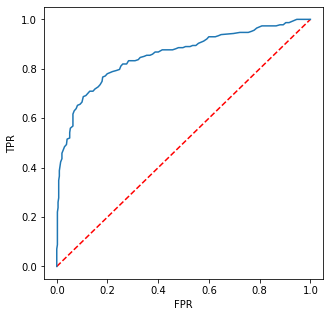

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
# False Positive Rate(FPR)와 True Positive Rate(TPR). ROC Curve에서의 수치
plt.plot(model.summary.roc.select('FPR').collect(),
         model.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

ML Pipeline 만들기

In [28]:
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, MinMaxScaler

# Gender
stringIndexer = StringIndexer(inputCol = "Gender", outputCol = 'GenderIndexed')

# Age
imputer = Imputer(strategy='mean', inputCols=['Age'], outputCols=['AgeImputed'])

# Vectorize
inputCols = ['Pclass', 'SibSp', 'Parch', 'Fare', 'AgeImputed', 'GenderIndexed']
assembler = VectorAssembler(inputCols=inputCols, outputCol="features")

# MinMaxScaler
minmax_scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")

stages = [stringIndexer, imputer, assembler, minmax_scaler]

In [29]:
from pyspark.ml.classification import LogisticRegression

algo = LogisticRegression(featuresCol="features_scaled", labelCol="Survived")
lr_stages = stages + [algo]

In [30]:
lr_stages

[StringIndexer_46a6b02d7984,
 Imputer_272695863da5,
 VectorAssembler_a6598f839b3f,
 MinMaxScaler_de001d3bc6f7,
 LogisticRegression_2725e82efd51]

In [31]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = lr_stages)

In [32]:
df = data.select(['Survived', 'Pclass', 'Gender', 'Age', 'SibSp', 'Parch', 'Fare'])
df.show()

+--------+------+------+----+-----+-----+-------+
|Survived|Pclass|Gender| Age|SibSp|Parch|   Fare|
+--------+------+------+----+-----+-----+-------+
|       0|     3|  male|22.0|    1|    0|   7.25|
|       1|     1|female|38.0|    1|    0|71.2833|
|       1|     3|female|26.0|    0|    0|  7.925|
|       1|     1|female|35.0|    1|    0|   53.1|
|       0|     3|  male|35.0|    0|    0|   8.05|
|       0|     3|  male|null|    0|    0| 8.4583|
|       0|     1|  male|54.0|    0|    0|51.8625|
|       0|     3|  male| 2.0|    3|    1| 21.075|
|       1|     3|female|27.0|    0|    2|11.1333|
|       1|     2|female|14.0|    1|    0|30.0708|
|       1|     3|female| 4.0|    1|    1|   16.7|
|       1|     1|female|58.0|    0|    0|  26.55|
|       0|     3|  male|20.0|    0|    0|   8.05|
|       0|     3|  male|39.0|    1|    5| 31.275|
|       0|     3|female|14.0|    0|    0| 7.8542|
|       1|     2|female|55.0|    0|    0|   16.0|
|       0|     3|  male| 2.0|    4|    1| 29.125|


In [33]:
train, test = df.randomSplit([0.7, 0.3])

In [34]:
lr_model = pipeline.fit(train)
lr_predictions = lr_model.transform(test)
evaluator.evaluate(lr_predictions)

0.8069230769230775

ML Tuning

In [35]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol='Survived', metricName='areaUnderROC')

In [36]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(algo.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)


In [37]:
# Run cross validations.
cvModel = cv.fit(train)
lr_cv_predictions = cvModel.transform(test)
evaluator.evaluate(lr_cv_predictions)

0.8067765567765574

In [38]:
lr_cv_predictions.select("prediction", "survived").show()

+----------+--------+
|prediction|survived|
+----------+--------+
|       0.0|       0|
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       1.0|       0|
|       1.0|       0|
+----------+--------+
only showing top 20 rows



In [39]:
import pandas as pd

params = [{p.name: v for p, v in m.items()} for m in cvModel.getEstimatorParamMaps()]
pd.DataFrame.from_dict([
    {cvModel.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, cvModel.avgMetrics)
])

,areaUnderROC,maxIter
0,0.846440,1
1,0.862195,5
2,0.863034,10


GBT Classifier

In [40]:
from pyspark.ml.classification import GBTClassifier

# Gradient-Boosted Trees (GBTs) . Binary Classification에 사용
gbt = GBTClassifier(featuresCol="features_scaled", labelCol="Survived")
gbt_stages = stages + [gbt]

In [41]:
gbt_stages

[StringIndexer_46a6b02d7984,
 Imputer_272695863da5,
 VectorAssembler_a6598f839b3f,
 MinMaxScaler_de001d3bc6f7,
 GBTClassifier_76e03444192a]

In [42]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = gbt_stages)

In [43]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)

In [44]:
# Run cross validations.
cvModel = cv.fit(train)
lr_cv_predictions = cvModel.transform(test)
evaluator.evaluate(lr_cv_predictions)

0.8163003663003664